<a id="1"></a>
<b><h3 style='border:0; color:Crimson'>HOMEWORK 2<h3></b>

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:crimson; border:0' role="tab" aria-controls="home"><center>Navigation</center></h3>

* [**Sigmoid and Relu**](#10)
* [**Evaluate model performance**](#20)
  
* [**DataSet and Visualization**](#30)
  * [Importing the datasets](#31)
  *
  * [Cleaning the data](#32)
  *
  * [Visualization](#33)
* [**Modeling**](#4)



<h3 style='background:crimson; border:0; color:white'><center>Overview<center><h3>

# Building a Neural Network from Scratch

https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65 

### Abstract Base Class : Layer
The abstract class Layer, which all other layers will inherit from, handles simple properties which are an input, an output, and both a forward and backward methods.

In [235]:

# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

In the abstract class above, backward_propagation function has an extra parameter, learning_rate, which is controlling the amount of learning/updating parameters using gradient descent.

### Backward Propagation
Suppose we have a matrix containing the derivative of the error with respect to that layer’s output: $\frac{\partial E}{\partial Y}$

We need :
- The derivative of the error with respect to the parameters ($\frac{\partial E}{\partial W}$, $\frac{\partial E}{\partial B}$)
- The derivative of the error with respect to the input ($\frac{\partial E}{\partial X}$)

Let's calculate $\frac{\partial E}{\partial W}$. This matrix should be the same size as $W$ itself : 

$i x j$ where $i$ is the number of input neurons and $j$ the number of output neurons. We need one gradient for every weight

### Coding the Fully Connected Layer

In [236]:
#from layer import Layer
import numpy as np

# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of edges that connects to neurons in next layer
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # dBias = output_error

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

### Activation Layer
All the calculation we did until now were completely linear, may not learn well. We need to add non-linearity to the model by applying non-linear functions to the output of some layers.

Now we need to redo the whole process for this new type of layer!

In [237]:
#from layer import Layer

# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

You can also write some activation functions and their derivatives in a separate file. These will be used later to create an ActivationLayer.

In [238]:
import numpy as np

# activation function and its derivative
def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;

### Loss Function
Until now, for a given layer, we supposed that ∂E/∂Y was given (by the next layer). But what happens to the last layer? How does it get ∂E/∂Y? We simply give it manually, and it depends on how we define the error.
The error of the network, which measures how good or bad the network did for a given input data, is defined by you. 

There are many ways to define the error, and one of the most known is called MSE — Mean Squared Error.

In [239]:

import numpy as np

# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

### Network Class
Almost done ! We are going to make a Network class to create neural networks very easily using the building blocks we have prepared so far.


In [240]:
# example of a function for calculating softmax for a list of numbers
from numpy import exp
 
# calculate the softmax of a vector
def softmax(vector):
    e = exp(vector)
    return e / e.sum()

In [241]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

        
    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network 
    
    def fit(self, x_train, y_train, epochs, learning_rate):
        '''
        Fit function does the training. 
        Training data is passed 1-by-1 through the network layers during forward propagation.
        Loss (error) is calculated for each input and back propagation is performed via partial 
        derivatives on each layer.
        '''
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))

### Building Neural Networks
Finally ! We can use our class to create a neural network with as many layers as we want ! We are going to build two neural networks : a simple XOR and a MNIST solver.

---

### Solve XOR
Starting with XOR is always important as it’s a simple way to tell if the network is learning anything at all.

In [242]:
import numpy as np

#from network import Network
#from fc_layer import FCLayer
#from activation_layer import ActivationLayer
#from activations import tanh, tanh_prime
#from losses import mse, mse_prime

# training data
x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

# network
net = Network()
net.add(FCLayer(2, 3))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(3, 1))
net.add(ActivationLayer(tanh, tanh_prime))

# train
net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=1000, learning_rate=0.1)

# test
out = net.predict(x_train)
print(out)

epoch 1/1000   error=0.439206
epoch 2/1000   error=0.316070
epoch 3/1000   error=0.297758
epoch 4/1000   error=0.292844
epoch 5/1000   error=0.290959
epoch 6/1000   error=0.290019
epoch 7/1000   error=0.289443
epoch 8/1000   error=0.289032
epoch 9/1000   error=0.288706
epoch 10/1000   error=0.288429
epoch 11/1000   error=0.288183
epoch 12/1000   error=0.287958
epoch 13/1000   error=0.287748
epoch 14/1000   error=0.287551
epoch 15/1000   error=0.287363
epoch 16/1000   error=0.287183
epoch 17/1000   error=0.287011
epoch 18/1000   error=0.286845
epoch 19/1000   error=0.286685
epoch 20/1000   error=0.286531
epoch 21/1000   error=0.286382
epoch 22/1000   error=0.286238
epoch 23/1000   error=0.286098
epoch 24/1000   error=0.285963
epoch 25/1000   error=0.285832
epoch 26/1000   error=0.285705
epoch 27/1000   error=0.285582
epoch 28/1000   error=0.285463
epoch 29/1000   error=0.285347
epoch 30/1000   error=0.285235
epoch 31/1000   error=0.285126
epoch 32/1000   error=0.285021
epoch 33/1000   e

---

### Solve MNIST
We didn’t implemented the Convolutional Layer but this is not a problem. 
All we need to do is to reshape our data so that it can fit into a Fully Connected Layer.
MNIST Dataset consists of images of digits from 0 to 9, of shape 28x28x1. 
The goal is to predict what digit is drawn on a picture.

In [243]:
import numpy as np

#from network import Network
#from fc_layer import FCLayer
#from activation_layer import ActivationLayer
#from activations import tanh, tanh_prime
#from losses import mse, mse_prime

from keras.datasets import mnist
from keras.utils import np_utils

# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = np_utils.to_categorical(y_train)

# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test)

# Network
net = Network()
net.add(FCLayer(28*28, 100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(100, 50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(50, 10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
net.add(ActivationLayer(tanh, tanh_prime))

# train on 1000 samples
# as we didn't implemented mini-batch GD, training will be pretty slow if we update at each iteration on 60000 samples...
net.use(mse, mse_prime)
net.fit(x_train[0:1000], y_train[0:1000], epochs=35, learning_rate=0.1)

# test on 3 samples
out = net.predict(x_test[0:3])
print("\n")
print("predicted values : ")
print(out, end="\n")
print("true values : ")
print(y_test[0:3])

epoch 1/35   error=0.248872
epoch 2/35   error=0.106703
epoch 3/35   error=0.086675
epoch 4/35   error=0.075300
epoch 5/35   error=0.066032
epoch 6/35   error=0.058296
epoch 7/35   error=0.052110
epoch 8/35   error=0.046991
epoch 9/35   error=0.042124
epoch 10/35   error=0.037729
epoch 11/35   error=0.033898
epoch 12/35   error=0.030649
epoch 13/35   error=0.027949
epoch 14/35   error=0.025887
epoch 15/35   error=0.024139
epoch 16/35   error=0.022764
epoch 17/35   error=0.021568
epoch 18/35   error=0.020423
epoch 19/35   error=0.019455
epoch 20/35   error=0.018549
epoch 21/35   error=0.017732
epoch 22/35   error=0.016947
epoch 23/35   error=0.016228
epoch 24/35   error=0.015588
epoch 25/35   error=0.014956
epoch 26/35   error=0.014362
epoch 27/35   error=0.013778
epoch 28/35   error=0.013218
epoch 29/35   error=0.012712
epoch 30/35   error=0.012256
epoch 31/35   error=0.011813
epoch 32/35   error=0.011386
epoch 33/35   error=0.010970
epoch 34/35   error=0.010662
epoch 35/35   error=0.0

In [244]:
print(x_test[0:3])

[[[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]]


Implement everything also use to find true positive and true negative

<a id="10"></a>
<h3 style='background:darkred; border:0; color:white'><center>Sigmoid and Relu<center></h3>

> **Sigmoid:** Convert that output to range between zero and one
> 
> $\frac{1}{1+e^-x}$

In [245]:
#Sigmoid Function
def sigmoid(x):
    w = 1/(1+np.exp(np.dot(-1, x)))
    cache = (x)
    return w, cache

sigmoid(0.5)

def sigmoid_prime(self, z):
    return self.sigmoid(z) * (1 - self.sigmoid(z))

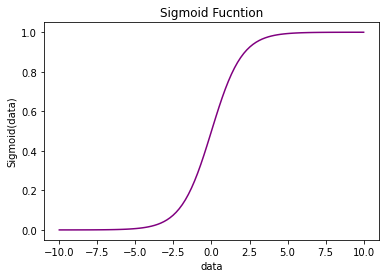

In [246]:
# Plotting sigmoid
import matplotlib.pyplot as plt

#some testing values and sigmoid function
data = np.linspace(-10, 10, 100) 
sigmoid = 1/(1 + np.exp(-data))

#Plotting
plt.plot(data, sigmoid, color = "purple")
plt.xlabel("data")
plt.ylabel("Sigmoid(data)")
plt.title("Sigmoid Fucntion")

plt.show()

> **Relu function:** Convert any negative output to zero, otherwise pass directly the positive value.
> 
> $ F(x) = max(0.0, x)$

In [247]:
#Relu function
def Relu(x):
    return max(0.0, x) #max return biggest item, so any negative value will become zero, but positive returns unchanged

def reluprime(x):
    return (x>0).astype(x.dtype)
    
print(Relu(-100))
print(Relu(100))


0.0
100


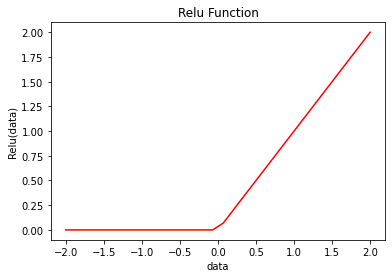

In [248]:
#Relu plotting
def relu(x):
    return(np.maximum(0, x))

#creating evenly spaced points for plotting
data = np.linspace(start = -2, stop = 2, num = 30)
relu_values = relu(data)

# Plot
plt.plot(data, relu_values, color = "red")
plt.xlabel("data")
plt.ylabel("Relu(data)")
plt.title("Relu Function")
plt.show()

<a id="20"></a>
<h3 style='background:darkred; border:0; color:white'><center>Evaluate model performance<center></h3>

> Creating method Evaluate and define accuracy, precision, recall and f1 score
> In order to evaluate the model first let's see how we can calculate them
>
>$Accuracy: \frac{TP + TN}{TP + FN + TN + FP}$ 
>
> $Precision: \frac{TP}{FP + TP} $
> 
> $Recall: \frac{TP}{FN + TP} $
>
>$F1: \frac {2 * Precision score * Recall score}{Precision score + Recall score} $

It"s important to define and get the TP, TN, FP and FN

In [249]:
class evaluate():
    np.random.seed(0)

    true_targ = np.random.randint(low=0,high=2,size=100) # true
    y_pred = np.random.randint(low=0,high=2,size=100) #pred

    '''
    We want to be able to compare our results with the actual libray
    so we're importing and testing Sklearn libraries at the same time
    '''

    #making our own confusion matrix
    def customConfusionMatrix(self,true_targ,y_pred):
        TP = 0 #True positive
        FP = 0 #False positive
        TN = 0 #True negative
        FN = 0 #False negative
        for y,y_pred in zip(true_targ,y_pred):
            if y==1 and y_pred==1:
                TP += 1
            elif y==0 and y_pred==0:
                TN += 1
            elif y==1 and y_pred==0:
                FN += 1
            elif y==0 and y_pred==1:
                FP += 1
                
        return np.array([[TN,FP],
                        [FN,TP]])


    # Built precision: TP/(FP+TP)
    def customPrecision(self,true_targ,y_pred):
        #setting initial value to zero
        TP = 0
        FP = 0
        for y,y_pred in zip(true_targ,y_pred):
            if y==1 and y_pred==1:
                TP += 1
            elif y == 0 and y_pred==1:
                FP +=1       
                
        return TP / (TP + FP)

    #Built Recall: TP / (FN + TP)
    def customRecall(self,true_targ,y_pred):
        #Initial value to zero to check if TP and FN
        TP = 0
        FN = 0
        for y,y_pred in zip(true_targ,y_pred):
            if y==1 and y_pred==1:
                TP += 1
            elif y == 1 and y_pred==0:
                FN +=1    
                
        return TP / (TP + FN)


    # Built F1 score: (2*precision*recall)/(precision+recall)
    def customF1Score(self,true_targ,y_pred): 
        #initialize the precision and recall
        precision=evaluate().customPrecision(true_targ, y_pred)
        recall=evaluate().customRecall(true_targ,y_pred)
        return 2 * (precision * recall) / (precision + recall)
    

    # Built Accurasy: (TP + TN)/(TP + FP + TN + FN)
    def customAccurasy(self,true_targ,y_pred):
        #Initializing values to zero
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for y,y_pred in zip(true_targ,y_pred):
            if y==1 and y_pred==1:
                TP += 1
            elif y==0 and y_pred==0:
                TN += 1
            elif y==1 and y_pred==0:
                FN += 1
            elif y==0 and y_pred==1:
                FP += 1
        return (TP+TN)/(TP+TN+FP+FN)


---

Our own created Confusion matrix

In [250]:
true = np.random.randint(low=0,high=2,size=100) #true
y= np.random.randint(low=0,high=2,size=100) #actual

eval = evaluate()
print("\nCustom Confusion Matrix:",eval.customConfusionMatrix(true,y),sep="\n")

print("\nCustom Precision = ",eval.customPrecision(true,y))

print("Custom Recall = ",eval.customRecall(true,y))    

print("Custom F1_Score = ",eval.customF1Score(true,y))

print("Custom Accuracy score = ",eval.customAccurasy(true,y))



Custom Confusion Matrix:
[[19 30]
 [21 30]]

Custom Precision =  0.5
Custom Recall =  0.5882352941176471
Custom F1_Score =  0.5405405405405405
Custom Accuracy score =  0.49


---

Sklearn imported confusion matrix, precision, accuracy, f1 and recall

In [251]:
#imports
from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score, confusion_matrix

true_targ = np.random.randint(low=0,high=2,size=100) #true
y_pred = np.random.randint(low=0,high=2,size=100) #actual

#Sklearn confusion matrix
print("Sklearn Confusion Matrix:",confusion_matrix(true_targ,y_pred),sep="\n")

#Sklearn precision
sklearn_precision = precision_score(true_targ,y_pred)
print("\nSklearn Precision = ",sklearn_precision)

# Sklearn Recall
sklearn_recall = recall_score(true_targ,y_pred)
print("Sklearn Recall = ",sklearn_recall)

#Sklearn F1 f1_score
sklearn_f1_score = f1_score(true_targ,y_pred)
print("Sklearn F1 score = ",sklearn_f1_score)

#Sklearn accuracy
sklearn_accuracy = accuracy_score(true_targ,y_pred)
print("Sklearn Accuracy score = ",sklearn_accuracy)

Sklearn Confusion Matrix:
[[27 23]
 [25 25]]

Sklearn Precision =  0.5208333333333334
Sklearn Recall =  0.5
Sklearn F1 score =  0.5102040816326531
Sklearn Accuracy score =  0.52


---

### Simple confusion matrix visualization

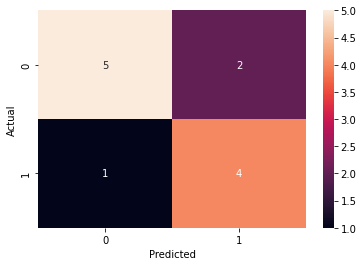

In [252]:
import pandas as pd
import seaborn as sn

data = {'y_Actual':    [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0],
        'y_Predicted': [1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0]
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

<a id="30"></a>
<h3 style='background:darkred; border:0; color:white;'><center>DataSet and Visualization</center></h3>

<a id="31"></a>
<h4 style='background:Darkred; border:0; color:white;'><center>Importing Dataset</center></h4>

In [253]:
iris = pd.read_csv("C:\\Users\\ayman\\OneDrive\\Coding-New\\Coding\\WORKSPACE\\PYTHON\\Deep learning\\w2\\Iris.csv")

Iris database is a purple colored flower 

In [254]:
iris

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [255]:
iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


<a id="32"></a>
<h4 style='background:Darkred; border:0; color:white;'><center>Cleaning and Normalization</center></h4>

Removing ID column as it already assigns an Index

In [256]:
iris.drop('Id',axis=1,inplace=True) 

In [257]:
iris.isnull() #checking for null values

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
145,False,False,False,False,False
146,False,False,False,False,False
147,False,False,False,False,False
148,False,False,False,False,False


In [258]:
iris.isnull().any()

SepalLengthCm    False
SepalWidthCm     False
PetalLengthCm    False
PetalWidthCm     False
Species          False
dtype: bool

We've no null values

In [259]:
iris.isnull().sum()

SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

> ### Null values
>We will use dropna if we'd a null value, ofc we can use different methods depending on the data
>> Mean median fill
>> 
>> forward and backward fill
>>
>> drop null values
>>
>> Fill with zeros

In [260]:
iris.dropna(inplace=True)

check if null values are removed

<AxesSubplot: >

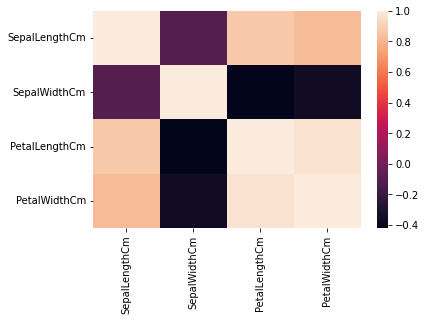

In [261]:
sn.heatmap(iris.corr())

<a id="33"></a>
<h3 style='background:darkred; border:0; color:white;'><center>Visualization</center></h3>

In [262]:
iris.head().style.background_gradient(cmap = "inferno")

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.100000,3.500000,1.400000,0.200000,Iris-setosa
1,4.900000,3.000000,1.400000,0.200000,Iris-setosa
2,4.700000,3.200000,1.300000,0.200000,Iris-setosa
3,4.600000,3.100000,1.500000,0.200000,Iris-setosa
4,5.000000,3.600000,1.400000,0.200000,Iris-setosa


In [263]:
iris.columns

Index(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')

In [264]:
iris.shape #rows and columns

(150, 5)

In [265]:
iris_large_petal=iris.sort_values("PetalWidthCm", axis = 0, ascending = False)
iris_large_petal

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
100,6.3,3.3,6.0,2.5,Iris-virginica
109,7.2,3.6,6.1,2.5,Iris-virginica
144,6.7,3.3,5.7,2.5,Iris-virginica
114,5.8,2.8,5.1,2.4,Iris-virginica
140,6.7,3.1,5.6,2.4,Iris-virginica
...,...,...,...,...,...
13,4.3,3.0,1.1,0.1,Iris-setosa
37,4.9,3.1,1.5,0.1,Iris-setosa
32,5.2,4.1,1.5,0.1,Iris-setosa
34,4.9,3.1,1.5,0.1,Iris-setosa


we can see that the largest petal width specie is Iris-virginica

In [266]:
iris_small_petal=iris.sort_values("PetalWidthCm", axis=0, ascending=True)
iris_small_petal

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
32,5.2,4.1,1.5,0.1,Iris-setosa
13,4.3,3.0,1.1,0.1,Iris-setosa
37,4.9,3.1,1.5,0.1,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa
12,4.8,3.0,1.4,0.1,Iris-setosa
...,...,...,...,...,...
140,6.7,3.1,5.6,2.4,Iris-virginica
114,5.8,2.8,5.1,2.4,Iris-virginica
100,6.3,3.3,6.0,2.5,Iris-virginica
144,6.7,3.3,5.7,2.5,Iris-virginica


smallest specie is Iris-setosa

In [267]:
no_duplicate=iris[~iris.duplicated('Species')]
no_duplicate

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
50,7.0,3.2,4.7,1.4,Iris-versicolor
100,6.3,3.3,6.0,2.5,Iris-virginica


The reason why we're defining new df is because we don't want to change the main csv sort

In [268]:
iris

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


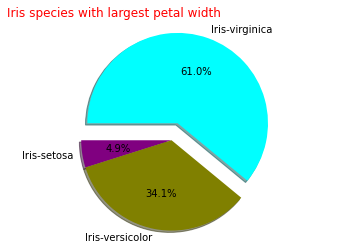

In [269]:
species_label = no_duplicate['Species']
sizes = no_duplicate['PetalWidthCm']
label=list(species_label)


colors = ['purple', 'olive', 'aqua']
plt.pie(sizes, explode=[0.0, 0.0, 0.2], labels=label, colors=colors, autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
#plt.legend()
plt.title('Iris species with largest petal width',loc='left',color='r')
plt.show()

We can see that virginica has the largest pedal with then versicolor then setosa

---

> ### Normalization and Frequency distributions

C:\Users\ayman\AppData\Local\Temp\ipykernel_12636\1056205214.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = iris.drop('Species',1) # axis=1, all data without species


X_scaled type is <class 'numpy.ndarray'>


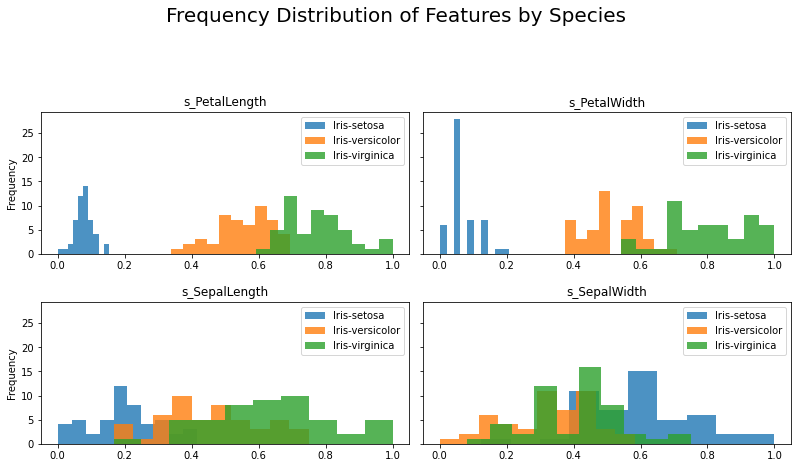

,s_SepalLength,s_SepalWidth,s_PetalLength,s_PetalWidth
count,150.000000,150.000000,150.000000,150.000000
mean,0.428704,0.439167,0.467571,0.457778
std,0.230018,0.180664,0.299054,0.317984
min,0.000000,0.000000,0.000000,0.000000
25%,0.222222,0.333333,0.101695,0.083333
50%,0.416667,0.416667,0.567797,0.500000
75%,0.583333,0.541667,0.694915,0.708333
max,1.000000,1.000000,1.000000,1.000000


In [270]:
from sklearn import preprocessing
# First we need to split X, Y into separate sets to feed X to the scaler.
X = iris.drop('Species',1) # axis=1, all data without species
Y = iris.Species #species

# Scaling of X
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
print('X_scaled type is',type(X_scaled))

# As output of scaler is np array I'll transform back to dataframe for easier exploration and plotting
X_scaled_df = pd.DataFrame(X_scaled,columns=['s_SepalLength','s_SepalWidth',
                                             's_PetalLength','s_PetalWidth'])
df = pd.concat([X_scaled_df,Y],axis=1)

# Notice x-axis on subplots are all the same for all features (0 to 1) after scaling.
fig = plt.figure(figsize=(12,7))
fig.suptitle('Frequency Distribution of Features by Species ',fontsize=20)

ax1 = fig.add_subplot(221)
df.groupby("Species").s_PetalLength.plot(kind='hist',alpha=0.8,legend=True,title='s_PetalLength')
ax2 = fig.add_subplot(222,sharey=ax1)
df.groupby("Species").s_PetalWidth.plot(kind='hist',alpha=0.8,legend=True,title='s_PetalWidth')
ax3 = fig.add_subplot(223,sharey=ax1)
df.groupby("Species").s_SepalLength.plot(kind='hist',alpha=0.8,legend=True,title='s_SepalLength')
ax4 = fig.add_subplot(224,sharey=ax1)
df.groupby("Species").s_SepalWidth.plot(kind='hist',alpha=0.8,legend=True,title='s_SepalWidth')

plt.tight_layout(pad=4, w_pad=1, h_pad=1.5)
plt.show()
X_scaled_df.describe()

Remove white space

In [271]:
iris = iris.applymap(lambda x: " ".join(x.split()) if isinstance(x, str) else x)

In [272]:
iris.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SepalLengthCm,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
SepalWidthCm,150.0,3.054000,0.433594,2.0,2.8,3.00,3.3,4.4
PetalLengthCm,150.0,3.758667,1.764420,1.0,1.6,4.35,5.1,6.9
PetalWidthCm,150.0,1.198667,0.763161,0.1,0.3,1.30,1.8,2.5


<h3 style='color:red'><center>2d PCA PLOT</center></h3>

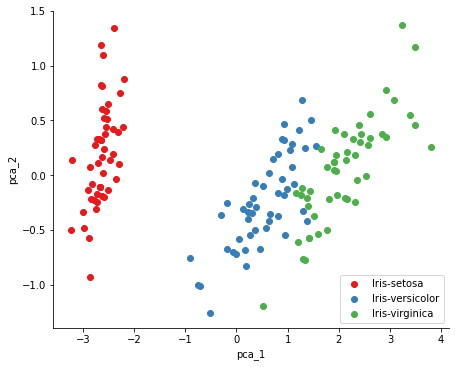

In [273]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit_transform(X) # pca output is an array
pca_df = pd.DataFrame(pca,columns=['pca_1','pca_2']) # transforming back to df
pca_Y = pd.concat([pca_df, Y],axis=1)

sn.FacetGrid(pca_Y, hue="Species", palette="Set1").map(plt.scatter, "pca_1", "pca_2").fig.set_size_inches(8, 6)
plt.legend()
plt.show()

Since they all cluster really well, then training the model and accuracy should be high

<a id="4"></a>
<h3 style='background:darkred; border:0; color:white;'><center>Modeling</center></h3>

classification and Accuracy score test

In [274]:
# Let's now build a classifier and evaluate accuracy
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 0)
print("train sample size",x_train.shape,type(x_train))
print("test sample size",x_test.shape,type(x_test))

train sample size (105, 4) <class 'pandas.core.frame.DataFrame'>
test sample size (45, 4) <class 'pandas.core.frame.DataFrame'>


<h4 style='background:crimson; border:0; color:white'><center><center>Classification</h4>

In [275]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

classifier = SVC(kernel = 'linear')
classifier.fit(x_train,y_train)
classifier.predict(x_train)
y_predict = classifier.predict(x_test)

# Creates a confusion matrix
cm = confusion_matrix(y_test, y_predict) 

precision, accuracy, f1 and recall

In [276]:
#Sklearn precision
sklearn_precision = precision_score(y_test,y_predict,average='micro')
print("\nSklearn Precision = ",sklearn_precision)

# Sklearn Recall
sklearn_recall = recall_score(y_test,y_predict,average='micro')
print("Sklearn Recall = ",sklearn_recall)

#Sklearn F1 f1_score
sklearn_f1_score = f1_score(y_test,y_predict,average='micro')
print("Sklearn F1 score = ",sklearn_f1_score)

#Sklearn accuracy
sklearn_accuracy = accuracy_score(y_test,y_predict)
print("Sklearn Accuracy score = ",sklearn_accuracy)


Sklearn Precision =  0.9777777777777777
Sklearn Recall =  0.9777777777777777
Sklearn F1 score =  0.9777777777777777
Sklearn Accuracy score =  0.9777777777777777


Plotting confusion matrix

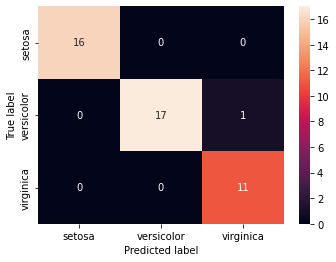

In [277]:
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['setosa','versicolor','virginica'], 
                     columns = ['setosa','versicolor','virginica'])

plt.figure(figsize=(5.5,4))
sn.heatmap(cm_df, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Custom built neural network class

In [278]:
#network
ann = Network()
ann.add(FCLayer(2,3))
ann.add(ActivationLayer(sigmoid, sigmoid_prime))
ann.add(FCLayer(3,1))
ann.add(ActivationLayer(sigmoid, sigmoid_prime))

x = iris.drop('Species',1) # axis=1, all data without species
y = iris.Species #species

# Scaling of X
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(x)
print('X_scaled type is',type(X_scaled))

# Let's now build a classifier and evaluate accuracy
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state = 0)

#train
ann.use(mse,mse_prime)
ann.fit(x_train,y_train,epochs=500, learning_rate=0.1)

#test
out = ann.predict(x_train)
print(out)

X_scaled type is <class 'numpy.ndarray'>


C:\Users\ayman\AppData\Local\Temp\ipykernel_12636\4114885408.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = iris.drop('Species',1) # axis=1, all data without species


ValueError: shapes (4,) and (2,3) not aligned: 4 (dim 0) != 2 (dim 0)

From what i understand is that my data simply needs to reshape in order to fit 2d 
however, after trying countless number of times i came up with nothing just another errors,
Everything in the worksheet was done and tested correctly except this last and probably the simplest
part I'm sure that it has to do with my data and that trying a different dataset would probably fix it
but trying a custom built version of neural network is a great idea to learn how it works, but trying 
to implement it over a dataset after normalization and all the rest is just too confusing, especially 
how complicated the actual library is and how there's a lot of other parameters like average in score 
are important, also i was really confused when you wanted us to compare the "network" with sklearn library 
but you didn't specify what to use so i just went with confusion matrix. Please if you're able to fix
the error in the last cell can you share it with me, Also please don't be too harsh in grading.
Best.

In [ ]:
print("\nCustom Precision = ",eval.customPrecision(y_test,y_predict))

print("Custom Recall = ",eval.customRecall(y_test,y_predict))

print("Custom F1_Score = ",eval.customF1Score(y_test,y_predict))

print("Custom Accuracy score = ",eval.customAccurasy(y_test,y_predict))